# Notebook Introduction

**TL;DR**: 
This notebook compares 3 classificaiton models and 2 resampling techniques to find the highest F-1 score for identifying fraudulent transactions

<ins>**Contents**</ins>:
* [Library Imports](#Library-Imports)
* [Data Import](#Data-Import)
* [Modeling](#Modeling)
    * [Baseline Model & Model Metrics](#Baseline-Model-&-Model-Metrics)
    * [Gaussian Naive Bayes](#Gaussian-Naive-Bayes-(GNB))
    * [Random Forest](#Random-Forest-(RF))
    * [eXtreme Gradient Boosting (XGBoost)](#XGBoost-(XGB))

# Library Imports

In [1]:
# Dataframes
import pandas as pd
import numpy as np

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# # Model metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# # Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import functions.py file
import sys
sys.path.append('../')

from functions.functions import *

In [3]:
random_seed = 1

# Data Import

## Import Training Datasets

In [4]:
# Original Training Dataset
X_train = pd.read_csv('../data/processed/x_train.gz', compression='gzip')
y_train = pd.read_csv('../data/processed/y_train.gz', compression='gzip').values.ravel()
# y_train.dropna(inplace=True)

# Training Dataset resampled with SMOTE
X_train_smote = pd.read_csv('../data/processed/x_train_smote.gz', compression='gzip')
y_train_smote = pd.read_csv('../data/processed/y_train_smote.gz', compression='gzip').values.ravel()
# y_train_smote.dropna(inplace=True)

# Training Dataset resampled with Random Undersampling
X_train_under = pd.read_csv('../data/processed/x_train_under.gz', compression='gzip')
y_train_under = pd.read_csv('../data/processed/y_train_under.gz', compression='gzip').values.ravel()
# y_train_under.dropna(inplace=True)

# Training Dataset resampled with SMOTE and Random Undersampling
X_train_smote_under = pd.read_csv('../data/processed/x_train_smote_under.gz', compression='gzip')
y_train_smote_under = pd.read_csv('../data/processed/y_train_smote_under.gz', compression='gzip').values.ravel()
# y_train_smote_under.dropna(inplace=True)

## Import Test Datasets

In [5]:
X_test = pd.read_csv('../data/processed/x_test.gz', compression='gzip')
y_test = pd.read_csv('../data/processed/y_test.gz', compression='gzip').values.ravel()
# y_test.dropna(inplace=True)

# Modeling

## Dataframe to keep track of Scores & Predictions

In [6]:
# Build scores dataframes for comparison
scores_columns = ['Original', 'SMOTE', 'Undersampled', 'SMOTE & Undersampled']
# F1 scores
f1_scores_df = pd.DataFrame(columns=scores_columns)
# Recall scores
recall_scores_df = pd.DataFrame(columns=scores_columns)
# Predictions
preds_df = pd.DataFrame()
# Prediction Probabilities
preds_proba_df = pd.DataFrame()

## GridSearch

* The function we use makes use of sklearn's GridSearchCV function.  
* Grid Search is an **exhaustive search** using the parameter values that we provide, in order **to optimize our model**.
    * Not every possible parameter combination is tested, so we can not guarantee a globally optimal combination of parameter values.
    * The model will ony be as good as the possible combinations of parameters that we provide.
    * the more parameter combinations we input, the longer the model will take to run.

## Baseline Model & Model Metrics

Due to the high imbalance in our dataset, it is very easy to obtain a high accuracy by simply classifying every observation as the majority class (non-fraud).

In [7]:
# Baseline model that all predictions are majority class
y_pred_base = [0] * len(y_test)

# Calculate Accuracy of Baseline Model
acc_base = round(accuracy_score(y_test, y_pred_base), 5)
print('Baseline Model Accuracy: {}'.format(acc_base))

Baseline Model Accuracy: 0.99827


A model with this level of accuracy will initially seem highly successful, but once we realise it has not caught a single fraudulent transaction, we then realise that **we need a different performance metric to accuracy**.  
   * 99.83% Accuracy can still be used as a starting point, or baseline, from which more sophisticated models can improve upon.

Alternative metrics to Accuracy include:  

### Precision 
* Out of all the frauds our model predicted, what proportion were actually frauds?

\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
* Out of all the actual frauds, what proportion did our model detect?

\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
* Considers both Precision and Recall.  Can be interpreted as a weighted average of the two (harmonic mean)

\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}


**To avoid confusion in this project, True Positive refers to predicting fraud and it is a fraud.**

When seeking to classify fraudulent transactions, the **cost for misclassifying frauds** (False Negative) **is greater than misclassifying a legitimate transaction** (False Positive).
   * An undetected fraud could potentially cost the customer and bank a lot of money.
   * A legitimate transaction, flagged as fraud, may cause inconvenience for the customer and requires a team within the bank to authorize the transaction.
   
For our model we will **focus on the F1 Score** and place more emphasis on a high **Recall** rather than Precision.
* The F1 Score will be the most useful metric as it is includes Recall and Precision.
* Focusing on Recall as well, reflects the fact that classifying frauds (class 1) is more important than classifying legitimate transactions (class 0).

Confusion Matrix: 
TN: 85295 FP: 0 FN: 148 TP: 0


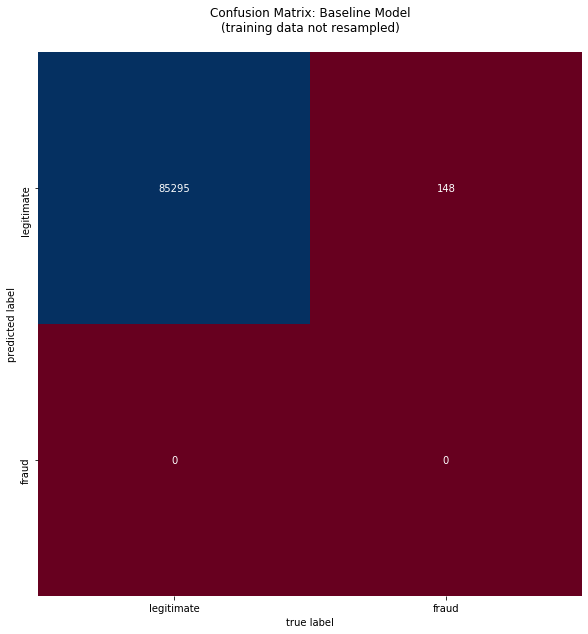

In [8]:
# Confusion matrix for baseline model
custom_confusion_matrix(y_test, y_pred_base, 'Baseline', 'not resampled')

In [9]:
# Calculate F1 Score of Baseline Model
f1_base = round(f1_score(y_test, y_pred_base), 8)
print('Baseline Model F1 Score: {}'.format(f1_base))

# Calculate Recall of Baseline Model
recall_base = round(recall_score(y_test, y_pred_base), 8)
print('Baseline Mode Recall Score: {}'.format(recall_base))

Baseline Model F1 Score: 0.0
Baseline Mode Recall Score: 0.0


Baseline Model's F1 Score and Recall are 0 as the baseline model has a True Positive of 0.

In [10]:
# Update F1 Scores table
f1_scores_df.loc['Baseline'] = [f1_base] * 4

# Update Recall Scores table
recall_scores_df.loc['Baseline'] = [recall_base] * 4

## Gaussian Naive Bayes (GNB)

<details><summary><strong>Classifier information</strong></summary>
    <br>

* This classification method is based on Bayes' Theorem and although it is one of the earliest classification techniques, it is still extremey powerful.  
* The classifier is essentially asking, "given the Amount = X, the V1 = Y, V2 = Z etc...what is the most likely Class for this observation?"
    </details>

In [11]:
# Instantiate Gaussian Naive Bayes Classifer
clf_gnb = GaussianNB()

# Build Parameter Grid
param_grid_gnb = {}

In [12]:
# Gaussian Bayes with Original training data
print('GNB - Original Dataset:')
f1_gnb_original, recall_gnb_original, y_pred_gnb_original, y_pred_proba_gnb_original = best_model_score(clf_gnb, param_grid_gnb, X_train, y_train, X_test, y_test)

# Gaussian Bayes with SMOTE training data
print('\nGNB - SMOTE Dataset:')
f1_gnb_smote, recall_gnb_smote, y_pred_gnb_smote, y_pred_proba_gnb_smote = best_model_score(clf_gnb, param_grid_gnb, X_train_smote, y_train_smote, X_test, y_test)

# Gaussian Bayes with Random Undersampled training data
print('\nGNB - Random Undersampled Dataset:')
f1_gnb_under, recall_gnb_under, y_pred_gnb_under, y_pred_proba_gnb_under = best_model_score(clf_gnb, param_grid_gnb, X_train_under, y_train_under, X_test, y_test)

# Gaussian Bayes with SMOTE and Random Undersampled training data
print('\nGNB - SMOTE and Random Undersampled Dataset:')
f1_gnb_smote_under, recall_gnb_smote_under, y_pred_gnb_smote_under, y_pred_proba_gnb_smote_under = best_model_score(clf_gnb, param_grid_gnb, X_train_smote_under, y_train_smote_under, X_test, y_test)

GNB - Original Dataset:
Best Test Data F1 score: 	0.11738
Best Test Data Recall score: 	0.86486

GNB - SMOTE Dataset:
Best Test Data F1 score: 	0.11121
Best Test Data Recall score: 	0.86486

GNB - Random Undersampled Dataset:
Best Test Data F1 score: 	0.12187
Best Test Data Recall score: 	0.87162

GNB - SMOTE and Random Undersampled Dataset:
Best Test Data F1 score: 	0.10441
Best Test Data Recall score: 	0.87162


In [13]:
# Update F1 Scores table
f1_scores_df.loc['Gaussian Naive Bayes'] = [f1_gnb_original, f1_gnb_smote, f1_gnb_under, f1_gnb_smote_under]

# Update Recall Scores table
recall_scores_df.loc['Gaussian Naive Bayes'] = [recall_gnb_original, recall_gnb_smote, recall_gnb_under, recall_gnb_smote_under]

# Update Predictions table
preds = {'y_pred_gnb_original': y_pred_gnb_original, 'y_pred_gnb_smote':y_pred_gnb_smote, 'y_pred_gnb_under':y_pred_gnb_under, 'y_pred_gnb_smote_under':y_pred_gnb_smote_under}
gnb_preds_df = pd.DataFrame(preds)
preds_df = pd.concat([preds_df, gnb_preds_df], axis=1, sort=False)

# Update Predictions Probability table
preds_proba = {'y_pred_proba_gnb_original': list(y_pred_proba_gnb_original), 'y_pred_proba_gnb_smote':list(y_pred_proba_gnb_smote), 'y_pred_proba_gnb_under':list(y_pred_proba_gnb_under), 'y_pred_proba_gnb_smote_under':list(y_pred_proba_gnb_smote_under)}
gnb_preds_proba_df = pd.DataFrame(preds_proba)
preds_proba_df = pd.concat([preds_proba_df, gnb_preds_proba_df], axis=1, sort=False)

## Random Forest (RF)

<details><summary><strong>Classifier information</strong></summary>
    <br>

* A Random Forest classifier uses an ensemble of decision trees that are trained using different portions of the data and different combinations of features. The forests predicts based on what the majority of trees in the forest predict.
    </details>



In [14]:
# Instantiate Random Forest Classifer
clf_rf = RandomForestClassifier(criterion='gini', 
                                class_weight={0: 1, 1: 2}, 
                                n_jobs=-1, 
                                random_state=random_seed)

# Build Parameter Grid
param_grid_rf = {'n_estimators': [50], 
                   'max_depth': [30, None], 
                 'min_samples_leaf': [1,3], 
                   'min_samples_split': [3,4]
                  }

<details><summary><strong>Parameter Tuning Guide<strong></summary>
    <br>

*criterion*
* The function to measure the quality of a split.
* "Gini" (Gini impurity) will often produce the same results as "Entropy" (information gain) but Entropy is more computaionally expensive.

*class_weight*
* Weights associated with classes in the form {class_label: weight}.
* We want our model to focus more on catching frauds, than catching legitimate transactions.

*n_estimators*
* Increasing this will improve the model as predictions will be based off a larger number of "votes", but it will also make it more computationally expensive

*max_depth*
* The max depth of the trees.  
* Too large and we risk overfitting the data.
* Too small and we prevent the trees being able to explain some of the variation in the data.

*min_samples_leaf*
* Minimum number of samples required to be at a leaf node.  
* Too large will risk the trees not splitting enough to capture sufficient variation in the data

*min_samples_split*
* Minimum number of samples required to split an internal node
* Too large will cause under-fitting as the trees won't be able to split enough to achieve node purity
    </details>

In [15]:
# Random Forest with Original training data
print('RF - Original Dataset:')
f1_rf_original, recall_rf_original, y_pred_rf_original, y_pred_proba_rf_original = best_model_score(clf_rf, param_grid_rf, X_train, y_train, X_test, y_test)

# Random Forest with SMOTE training data
print('\nRF - SMOTE Dataset:')
f1_rf_smote, recall_rf_smote, y_pred_rf_smote, y_pred_proba_rf_smote = best_model_score(clf_rf, param_grid_rf, X_train_smote, y_train_smote, X_test, y_test)

# Random Forest with Random Undersampled training data
print('\nRF - Random Undersampled Dataset:')
f1_rf_under, recall_rf_under, y_pred_rf_under, y_pred_proba_rf_under = best_model_score(clf_rf, param_grid_rf, X_train_under, y_train_under, X_test, y_test)

# Random Forest with SMOTE and Random Undersampled training data
print('\nRF - SMOTE and Random Undersampled Dataset:')
f1_rf_smote_under, recall_rf_smote_under, y_pred_rf_smote_under, y_pred_proba_rf_smote_under = best_model_score(clf_rf, param_grid_rf, X_train_smote_under, y_train_smote_under, X_test, y_test)

RF - Original Dataset:
Best Test Data F1 score: 	0.88571
Best Test Data Recall score: 	0.83784

Optimal parameters:
	max_depth: 30
	min_samples_leaf: 1
	min_samples_split: 3
	n_estimators: 50

RF - SMOTE Dataset:
Best Test Data F1 score: 	0.87973
Best Test Data Recall score: 	0.86486

Optimal parameters:
	max_depth: None
	min_samples_leaf: 1
	min_samples_split: 3
	n_estimators: 50

RF - Random Undersampled Dataset:
Best Test Data F1 score: 	0.22259
Best Test Data Recall score: 	0.89865

Optimal parameters:
	max_depth: 30
	min_samples_leaf: 3
	min_samples_split: 3
	n_estimators: 50

RF - SMOTE and Random Undersampled Dataset:
Best Test Data F1 score: 	0.82243
Best Test Data Recall score: 	0.89189

Optimal parameters:
	max_depth: 30
	min_samples_leaf: 1
	min_samples_split: 4
	n_estimators: 50


In [16]:
# Update F1 Scores table
f1_scores_df.loc['Random Forest'] = [f1_rf_original, f1_rf_smote, f1_rf_under, f1_rf_smote_under]

# Update Recall Scores table
recall_scores_df.loc['Random Forest'] = [recall_rf_original, recall_rf_smote, recall_rf_under, recall_rf_smote_under]

# Update Predictions table
preds = {'y_pred_rf_original': y_pred_rf_original, 'y_pred_rf_smote':y_pred_rf_smote, 'y_pred_rf_under':y_pred_rf_under, 'y_pred_rf_smote_under':y_pred_rf_smote_under}
rf_preds_df = pd.DataFrame(preds)
preds_df = preds_df.join(rf_preds_df)

# Update Predictions Probability table
preds_proba = {'y_pred_proba_rf_original': list(y_pred_proba_rf_original), 'y_pred_proba_rf_smote': list(y_pred_proba_rf_smote), 'y_pred_proba_rf_under':list(y_pred_proba_rf_under), 'y_pred_proba_rf_smote_under': list(y_pred_proba_rf_smote_under)}
rf_preds_proba_df = pd.DataFrame(preds_proba)
preds_proba_df = pd.concat([preds_proba_df, rf_preds_proba_df], axis=1, sort=False)

## XGBoost (XGB)

<details><summary><strong>Classifier information</strong></summary>
    <br>

eXtreme Gradient Boosting (XGBoost) is a form of gradient-boosted decision trees. 

In a standard ensemble method such as Random Forest, models are trained in isolation so all of the models might make the same mistakes.

Gradient Boosting methods, such as XGBoost, trains the Trees in succession.  
* Each new Tree is trained to correct the errors made by the previous Trees.  
* Trees are added sequentially until either no further improvements can be made or a specified number of trees is reached.
* Note that Boosted classifiers do not necessarily have to be tree-based, though often are.
    </details>

In [18]:
# Instantiate XGBClassifier
scale_pos_weight = 10
clf_xgb = XGBClassifier(booster='gbtree', tree_method='hist', scale_pos_weight=scale_pos_weight, verbosity=0,
                    seed=random_seed
                   )

# Build Parameter Grid
param_grid_xgb = {
    'learning_rate': [0.2, 0.3],
    'objective': ['binary:hinge'],
    'max_depth': [30, 50],
    'min_child_weight': [3],
}

<details><summary><strong>Parameter Tuning Guide<strong></summary>
    <br>

*booster*
* "gbtree" uses tree based models

*tree_method*
* "hist" allows for faster computation

*scale_pos_weight
* Ratio of legitimate transactions to frauds.
* This helps the model deal with imbalanced datasets.

*learning_rate*
* This is the step size shrinkage used in each update.  It prevents overfitting

*objective*
* "binary:hinge" is for binary classification.  A prediction of 0 or 1 is output, rather than producing probabilities

*max_depth*
* Max number of nodes from root to furthest leaf.
* Too large and splits will eventually become less relevant and overfitting will occur.
* Too small and we won't be able to model more complex relationships in the data.

*min_child_weight*
* Min weight or number of samples needed to create a new node.
* Too large and our model will not be able to create children to correspond to 
* Too small and we risk overfitting

In [19]:
# XGBoost with Original training data
print('XGB - Original Dataset:')
# Class weights
(y_class, y_train_counts) = np.unique(y_train, return_counts=True) # Value counts for Class 0 and 1
clf_xgb.scale_pos_weight = y_train_counts[0] / y_train_counts[1] # Ratio of Class 1: Class 0

# Fit model
f1_xgb_original, recall_xgb_original, y_pred_xgb_original, y_pred_proba_xgb_original = best_model_score(clf_xgb, 
                                                                                                        param_grid_xgb, 
                                                                                                        X_train, 
                                                                                                        y_train, 
                                                                                                        X_test, 
                                                                                                        y_test)


# XGBoost with SMOTE training data
print('\nXGB - SMOTE Dataset:')
# Class weights
(y_class, y_train_smote_counts) = np.unique(y_train_smote, return_counts=True)
clf_xgb.scale_pos_weight = y_train_smote_counts[0] / y_train_smote_counts[1]

# Fit model
f1_xgb_smote, recall_xgb_smote, y_pred_xgb_smote, y_pred_proba_xgb_smote = best_model_score(clf_xgb, 
                                                                                            param_grid_xgb, 
                                                                                            X_train_smote, 
                                                                                            y_train_smote, 
                                                                                            X_test, 
                                                                                            y_test)

# XGBoost with Random Undersampled training data
print('\nXGB - Random Undersampled Dataset:')
# Class weights
(y_class, y_train_under_counts) = np.unique(y_train_under, return_counts=True)
clf_xgb.scale_pos_weight = y_train_under_counts[0] / y_train_under_counts[1]

# Fit model
f1_xgb_under, recall_xgb_under, y_pred_xgb_under, y_pred_proba_xgb_under = best_model_score(clf_xgb, 
                                                                                            param_grid_xgb, 
                                                                                            X_train_under, 
                                                                                            y_train_under, 
                                                                                            X_test, 
                                                                                            y_test)
# XGBoost with SMOTE and Random Undersampled training data
print('\nXGB - SMOTE and Random Undersampled Dataset:')
# Class weights
(y_class, y_train_smote_under_counts) = np.unique(y_train_smote_under, return_counts=True)
clf_xgb.scale_pos_weight = y_train_smote_under_counts[0] / y_train_smote_under_counts[1]

# Fit model
f1_xgb_smote_under, recall_xgb_smote_under, y_pred_xgb_smote_under, y_pred_proba_xgb_smote_under = best_model_score(clf_xgb, 
                                                                                                                    param_grid_xgb, 
                                                                                                                    X_train_smote_under, 
                                                                                                                    y_train_smote_under, 
                                                                                                                    X_test, 
                                                                                                                    y_test)

XGB - Original Dataset:
Best Test Data F1 score: 	0.86525
Best Test Data Recall score: 	0.82432

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge

XGB - SMOTE Dataset:
Best Test Data F1 score: 	0.86195
Best Test Data Recall score: 	0.86486

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge

XGB - Random Undersampled Dataset:
Best Test Data F1 score: 	0.11703
Best Test Data Recall score: 	0.89865

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge

XGB - SMOTE and Random Undersampled Dataset:
Best Test Data F1 score: 	0.6514
Best Test Data Recall score: 	0.86486

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge


In [20]:
# Update F1 Scores table
f1_scores_df.loc['XGBoost'] = [f1_xgb_original, f1_xgb_smote, f1_xgb_under, f1_xgb_smote_under]

# Update Recall Scores table
recall_scores_df.loc['XGBoost'] = [recall_xgb_original, recall_xgb_smote, recall_xgb_under, recall_xgb_smote_under]

# Update Predictions table
preds = {'y_pred_xgb_original': y_pred_xgb_original, 'y_pred_xgb_smote':y_pred_xgb_smote, 'y_pred_xgb_under':y_pred_xgb_under, 'y_pred_xgb_smote_under':y_pred_xgb_smote_under}
xgb_preds_df = pd.DataFrame(preds)
preds_df = preds_df.join(xgb_preds_df)

# Update Predictions Probability table
preds_proba = {'y_pred_proba_xgb_original': list(y_pred_proba_xgb_original), 'y_pred_proba_xgb_smote': list(y_pred_proba_xgb_smote), 'y_pred_proba_xgb_under': list(y_pred_proba_xgb_under), 'y_pred_proba_xgb_smote_under': list(y_pred_proba_xgb_smote_under)}
xgb_preds_proba_df = pd.DataFrame(preds_proba)
preds_proba_df = pd.concat([preds_proba_df, xgb_preds_proba_df], axis=1, sort=False)

# Save Results Table

In [51]:
# Save F1 Scores Table
f1_scores_df.to_csv('../data/processed/f1_scores')

# Save F1 Scores Table
recall_scores_df.to_csv('../data/processed/recall_scores')

# Predictions Table
preds_df.to_csv('../data/processed/predictions')

# # Prediction Probability Table
preds_proba_df.to_pickle('../data/processed/predictions_probabilities.pkl')